In [2]:
from pathlib import Path
from matplotlib import pyplot as plt
from pybeerxml import Parser
from scipy import stats
import sys
import numpy as np
import re
import csv
import json
import concurrent.futures
import pandas as pd
import math
import random

sys.path.append('../')
from brewgen.backend.models import grain, category, hop

In [3]:
with open('styleguide-2015.json', 'r') as f:
    bjcp = json.load(f)

In [4]:
def bjcp_name(name):
    """Return beer stats for a style name"""
    for bev_class in bjcp['styleguide']['class']:
        if bev_class['type'] == 'beer':
            for style_category in bev_class['category']:
                for subcat in style_category['subcategory']:
                    if subcat['name'] == name:
                        return subcat.get('stats', {})

                    
def points(og):
    return (og - 1) * 1000

In [5]:
style_rewrites = [
    {
        'new': 'California Common',
        'old': '^.*California Common Beer.*$'
    },
    {
        'new': 'Historical Beer: Gose',
        'old': '^.*Gose.*$'
    },
    {
        'new': 'International Dark Lager',
        'old': '^.*Dark American Lager.*$'
    },
    {
        'new': 'Specialty Smoked Beer',
        'old': '^Other Smoked Beer$'
    },
    {
        'new': 'Historical Beer: Pre-Prohibition Lager',
        'old': '^.*(Classic American Pilsner|Pre-Prohibition Lager).*$'
    },
    {
        'new': 'Historical Beer: Kentucky Common',
        'old': '^.*Kentucky Common.*$'
    },
    {
        'new': 'Winter Seasonal Beer',
        'old': '^.*Holiday/Winter Special Spiced Beer.*$'
    },
    {
        'new': 'Ordinary Bitter',
        'old': '^.*Standard/Ordinary Bitter.*$'
    },
    {
        'new': 'British Brown Ale',
        'old': '^.*English Brown.*$'
    },
    {
        'new': 'International Lager',
        'old': '^.*Premium American Lager.*$'
    },
    {
        'new': 'Strong Bitter',
        'old': '^.*Strong Bitter.*$'
    },
    {
        'new': 'Imperial Stout',
        'old': '^.*Imperial Stout.*$'
    },
    {
        'new': 'American Wheat Beer',
        'old': '^.*American (Wheat|Rye).*$'
    },
    {
        'new': 'American Porter',
        'old': '^.*Robust Porter.*$'
    },
    {
        'new': 'Irish Stout',
        'old': '^.*Dry.*Stout.*$'
    },
    {
        'new': 'Experimental Beer',
        'old': '^.*Specialty Beer.*$'
    },
    {
        'new': 'Best Bitter',
        'old': '^.*Best.*Bitter.*$'
    },
    {
        'new': 'Weissbier',
        'old': '^.*(Weizen|Weissbier).*$'
    },
    {
        'new': 'Double IPA',
        'old': '^.*Imperial IPA.*$'
    },
    {
        'new': 'German Pils',
        'old': '^.*German.*Pils.*$'
    },
    {
        'new': 'Märzen',
        'old': '^.*(Oktoberfest|M.rzen).*$'
    },
    {
        'new': 'Altbier',
        'old': '^.*(D.sseldorf|Altbier).*$'
    },
    {
        'new': 'Scottish Export',
        'old': '^.*Scottish.*Export.*$'
    },    {
        'new': 'Kölsch',
        'old': '^.*k.*lsch.*$'
    },    {
        'new': 'Dunkles Bock',
        'old': '^.*Traditional Bock.*$'
    },    {
        'new': 'Schwarzbier',
        'old': '^.*Schwarzbier.*$'
    },
    {
        'new': 'Dark Mild',
        'old': '^Mild$'
    },
    {
        'new': 'Helles Bock',
        'old': '^.*(Maibock|Helles Bock).*$'
    },
    {
        'new': 'Wee Heavy',
        'old': '^.*Strong Scotch.*$'
    },
    {
        'new': 'American Lager',
        'old': '^.*Standard American Lager.*$'
    },
    {
        'new': 'American Light Lager',
        'old': '^.*Li(ght|te) American Lager.*$'
    },
    {
        'new': 'American Light Lager',
        'old': '^.*American Lite Lager.*$'
    },
    {
        'new': 'Czech Premium Pale Lager',
        'old': '^.*Bohemian Pils.*$'
    },
    {
        'new': 'British Brown Ale',
        'old': 'Brown Porter'
    }
]

In [6]:
hop_rewrites = [{
  'match': '.*east.*kent.*',
  'replace': 'East Kent Golding (UK)'
},
{
  'match': '.*Galaxy.*',
  'replace': 'Galaxy (AU)'
},
{
  'match': '.*premiant.*',
  'replace': 'Premiant (CZ)'
},
{
  'match': '.*sladek.*',
  'replace': 'Sladek (CZ)'
},
{
  'match': '.*styrian.*celeia.*',
  'replace': 'Celeia (SI)'
},
{
  'match': '.*styrian.*golding.*',
  'replace': 'Golding (SI)'
},
{
  'match': '(Centennial|Citra|Amarillo|Cascade|Simcoe|Chinook|Columbus|Willamette|Nugget|Mosaic|Warrior|Crystal|Cluster|Summit|Cluster|Crystal|Liberty|Galena|Ahtanum|Sterling|Glacier|Palisade|El Dorado|Apollo|Horizon|Bravo|Calypso|Santiam|Newport|Super Galena).*\(US\)',
  'replace': '\g<1>'
},
{
  'match': '^.*bobek.*$',
  'replace': 'Bobek (SI)'
},
{
  'match': '^.*eureka.*$',
  'replace': 'Eureka'
},
{
  'match': '^.*h.*mittel.*$|^Mittel.*$',
  'replace': 'Hallertau Mittelfrüh (DE)'
},
{
  'match': '^.*hersbruck.*$',
  'replace': 'Hersbrucker (DE)'
},
{
  'match': '^.*nelson.*$',
  'replace': 'Nelson Sauvin (NZ)'
},
{
  'match': '^.*sorachi.*$',
  'replace': 'Sorachi Ace'
},
{
  'match': '^.*willam.*$',
  'replace': 'Willamette'
},
{
  'match': '^.*william.*$',
  'replace': 'Willamette'
},
{
  'match': '^(.*kent.*|golding.*uk.*|uk.*golding.*|.*ek.*|golding(|s))$',
  'replace': 'East Kent Golding (UK)'
},
{
  'match': '^(.*styrian.*a(|u)rora.*|super.*styrian.*)$',
  'replace': 'Aurora (SI)'
},
{
  'match': '^((ger|hal|gr|de).*magnum|magnum.*(ger|hal|gr|de).*)$',
  'replace': 'Magnum (DE)'
},
{
  'match': '^((Yakima|US) Magnum|Magnum|magnum.*us.*|us.*magnum.*)$',
  'replace': 'Magnum (US)'
},
{
  'match': '^(cz.*saaz|saaz|saaz.*cz.*)$',
  'replace': 'Saaz (CZ)'
},
{
  'match': '^(fugg.*(uk|u\.k\.).*|(uk|u\.k\.).*fugg.*|fuggle(|s))$',
  'replace': 'Fuggle (UK)'
},
{
  'match': '^(fugg.*(us|u\.s\.).*|(us|u\.s\.).*fugg.*)$',
  'replace': 'Fuggle (US)'
},
{
  'match': '^(german |)hallert(au|eau)(|er)(| \(de\))$',
  'replace': 'Hallertau Mittelfrüh (DE)'
},
{
  'match': '^(german |)hallertau(|er)(| \(de\))$',
  'replace': 'Hallertau Mittelfrüh (DE)'
},
{
  'match': '^(gold.*bread.*|.*bread.*gold.*)$',
  'replace': 'Whitbread Golding Variety (UK)'
},
{
  'match': '^(tettn(a|e)ng(|er)|(ger|gr|de).*tettn(a|e)ng(|er)|tettn(a|e)ng(|er).*(ger|gr|de).*)$',
  'replace': 'Tettnang (DE)'
},
{
  'match': '^(tettn(a|e)ng(|er)|(us|ych|u\.s\.).*tettn(a|e)ng(|er)|tettn(a|e)ng(|er).*(us|ych|u\.s\.).*)$',
  'replace': 'Tettnang (US)'
},
{
  'match': '^(us.*golding.*|golding.*us.*)$',
  'replace': 'Golding (US)'
},
{
  'match': '^(us.*saaz|saaz|saaz.*us.*)$',
  'replace': 'Saaz (US)'
},
{
  'match': '^m.*hood.*$',
  'replace': 'Mt. Hood'
},
{
  'match': 'Domestic Hallertau',
  'replace': 'Hallertau (US)'
}]

In [7]:
parser = Parser()

In [8]:
# Get all recipe paths
brewtoad = list(Path("./brewtoad_scrape").rglob("*.xml"))  # [0:120000]
brewers_friend = list(
    Path("./brewersfriend_scrape/recipes").rglob("*.xml"))  # [0:100000]

beerxml_list = brewtoad + brewers_friend
random.shuffle(beerxml_list)

In [9]:
def parse_beerxml_file(beerxml_file):
    try:
        recipe = parser.parse('./{}'.format(str(beerxml_file)))[0]
    except:
        print("Failed to parse ./{}".format(str(beerxml_file)))
        
    try:
        style = recipe.style.name

        # Rewrite style names
        for rule in style_rewrites:
            match = re.match(rule['old'], style, flags=re.IGNORECASE)
            if match:
                style = rule['new']
                recipe.style.name = rule['new']
                break
        
        # Rewrite hop data
        for recipe_hop in recipe.hops:
            for rule in hop_rewrites:
                re_rule = re.compile(r'{}'.format(rule['match']), flags=re.IGNORECASE)
                match = re.match(re_rule, str(recipe_hop.name).strip())
                if match:
                    recipe_hop.name = re.sub(re_rule, r'{}'.format(rule['replace']), str(recipe_hop.name).strip())
                    break

        return recipe
        
    except:
        pass

In [10]:
executor = concurrent.futures.ProcessPoolExecutor()
futures = executor.map(parse_beerxml_file, beerxml_list[0:100000]) #[0:100000]
parse_results = list(futures)

Failed to parse ./brewersfriend_scrape/recipes/recipe_690210.xml
Failed to parse ./brewtoad_scrape/recipes/fat-tire-675f4a/recipe.xml
Failed to parse ./brewtoad_scrape/recipes/alt-ter-ego-alt-beer/recipe.xml
Failed to parse ./brewtoad_scrape/recipes/ale-b673b6/recipe.xml


Process ForkProcess-1:
Process ForkProcess-4:
Traceback (most recent call last):
Process ForkProcess-2:
Process ForkProcess-3:
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/concurrent/futures/process.py", line 233, in _process_worker
    call_item = call_queue.get(block=True)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/pyth

In [11]:
recipes = [result for result in parse_results if result != None]
styles = np.unique(np.array([recipe.style.name for recipe in recipes]))
all_hops = hop.HopModel()

In [12]:
hop_use = []
hop_list = []
for recipe in recipes:
    for h in recipe.hops:
        if h.use:
            hop_use.append(h.use.lower())
            hop_list.append(h)

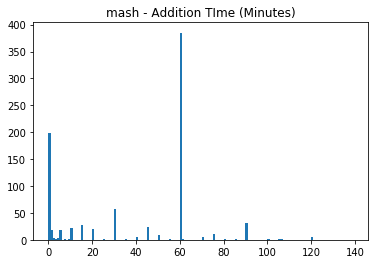

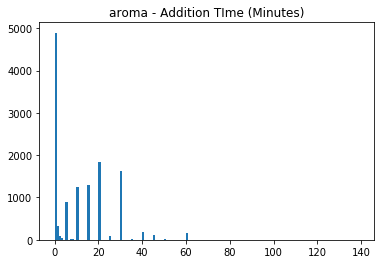

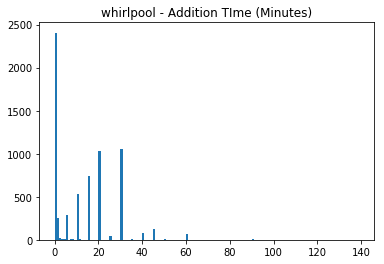

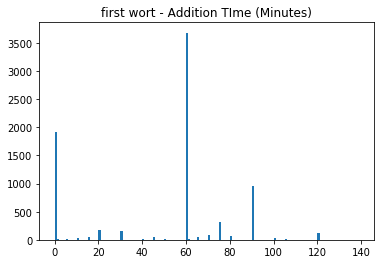

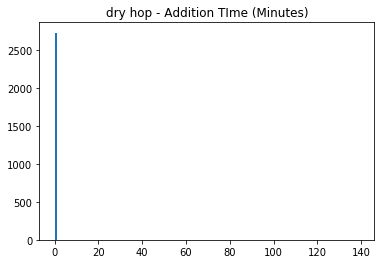

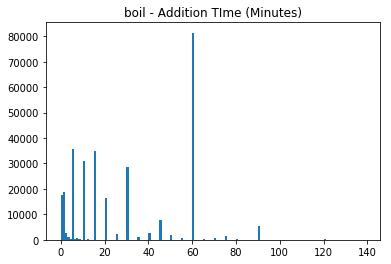

In [13]:
uses = list(set(hop_use))
for use in uses:
    use_list = [round(h.time) for h in hop_list if h.use.lower() == use]
    plt.title('{} - Addition TIme (Minutes)'.format(use))
    plt.hist(use_list, bins=range(0, 140))
    plt.show()

In [ ]:
for style in ['American IPA']:
    specs = bjcp_name(style) 
    style_recipes = [recipe for recipe in recipes if recipe.style.name == style]
    hop_additions = []
    hop_data = []
    flavor = []
    
    for recipe in style_recipes:
        try:
            boil_hops = [hop for hop in recipe.hops if hop.alpha and hop.use.lower() in ['boil', 'first wort']]
            dry_hops = [hop for hop in recipe.hops if hop.alpha and hop.use.lower() in ['dry hop']]
            whirl_hops = [hop for hop in recipe.hops if hop.alpha and hop.use.lower() in ['whirlpool', 'aroma']]

            if boil_hops:
                boil_amount = sum(hop.amount for hop in boil_hops)

                # Exclude recipes with more than 8oz/5gal or 226g/19L in the boil
                if boil_amount / recipe.batch_size > 0.01198:
                    continue

                ibu = [hop.bitterness('tinseth', recipe.og, recipe.batch_size) for hop in boil_hops]

                # Filter out recipes with out-of-style bitterness
                ibu_match = float(specs.get('ibu', {}).get('low', 0))*.75 <= sum(ibu) <= float(
                     specs.get('ibu', {}).get('high', 999))*1.25
                if not ibu_match:
                    continue

            else:
                # Ignore recipes with no boil hops
                continue

            # Exclude recipes with more than 1lb/5gal or 454g/19L in the whirlpool or dry hop
            non_boil_amount = sum(hop.amount for hop in dry_hops + whirl_hops)
            if non_boil_amount / recipe.batch_size > 0.02396:
                continue

            # Built a HopBill, ignore recipes where we can't match all hops
            for recipe_hop in boil_hops + dry_hops + whirl_hops:
                matching_hop = all_hops.get_hop_by_name(recipe_hop.name)
                if matching_hop:
                    hop_additions.append(hop.HopAddition(matching_hop, recipe_hop.time, recipe_hop.use, recipe_hop.amount))
                else: 
                    continue
            
            hop_bill = hop.HopBill(hop_additions)
            flavor.append(hop_bill.get_sensory_data(recipe.og, recipe.batch_size))
            amount = (boil_amount + non_boil_amount) / recipe.batch_size
            hop_data.append((amount, sum(ibu)))
        except:
            pass
    
#     ibu_data = [round(ibu) for _, ibu in hop_data]
#     plt.title('IBU')
#     plt.hist(ibu_data, bins=range(0, max(ibu_data)))
#     plt.show()

#     amount_data = [round(amount * 10000) for amount, _ in hop_data]
#     amt_std = np.std(amount_data)
#     amt_mean = np.mean(amt_std)
#     amt_usable = [n for n in amount_data if (amt_mean - 3 * amt_std) <= n <= (amt_mean + 3 * amt_std)]
#     plt.title('Amount (dg/L)')
#     plt.hist(amt_usable, bins=range(0, max(amt_usable)))
#     plt.show()
    
    for keyword in all_hops.get_sensory_keywords():
        flavor_data = [round(recipe_flavor[keyword]) for recipe_flavor in flavor if round(recipe_flavor[keyword]) > 0]
        if sum(flavor_data) > 0: 
            f_std = np.std(flavor_data)
            f_mean = np.mean(flavor_data)
            flavor_usable = [n for n in flavor_data if (f_mean - 3 * f_std) <= n <= (f_mean + 3 * f_std)]

            try:
                plt.title('Flavor: {}'.format(keyword))
                plt.hist(flavor_data, bins=range(0, max(flavor_data)))
                plt.show()
                print(flavor_data)
            except:
                print(flavor_data)

In [ ]:
hop_names = list(set(str(h).strip() for h in hop_list))
hop_totals = []
for hop_name in hop_names:
    hop_total = {
        'name': hop_name, 
        'total': sum(1 for h in hop_list if str(h).strip() == hop_name)
    }
    if hop_total['total'] > 100:
        hop_totals.append(hop_total)
        print(hop_total)

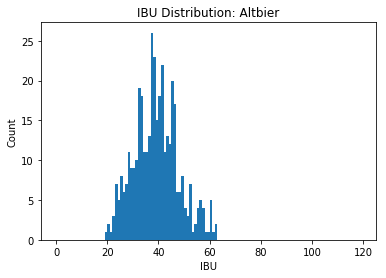

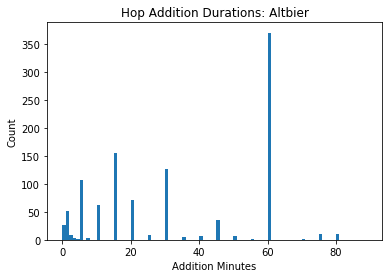

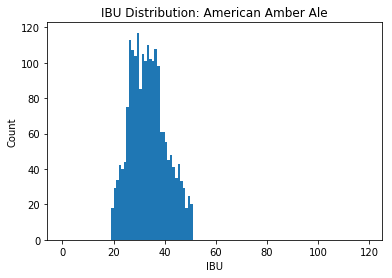

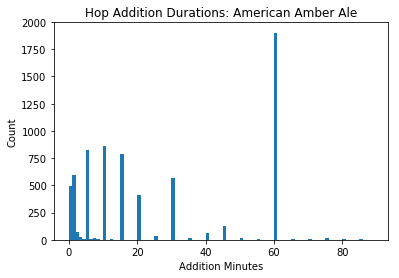

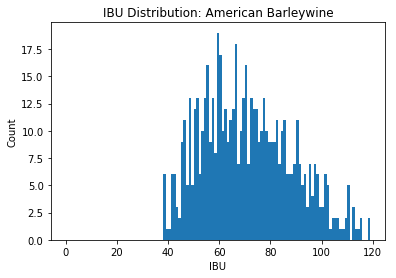

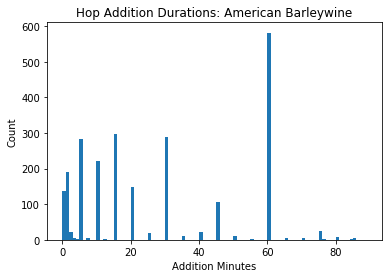

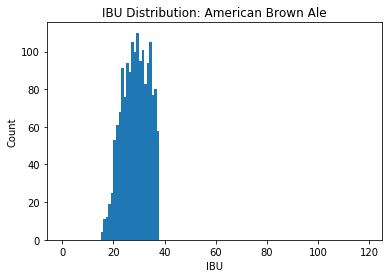

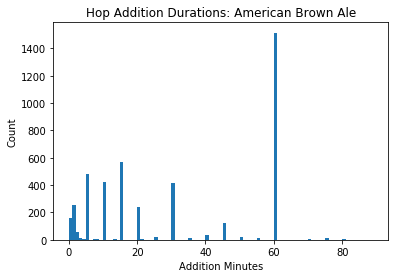

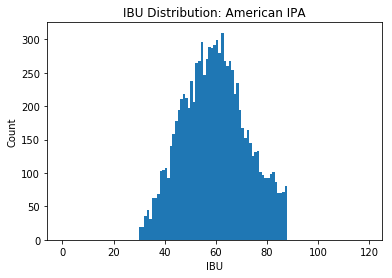

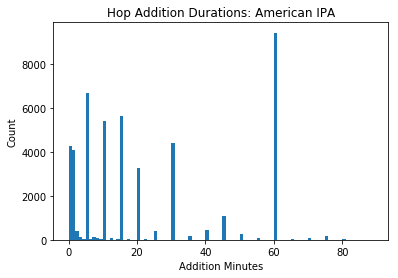

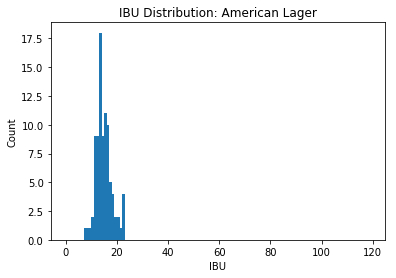

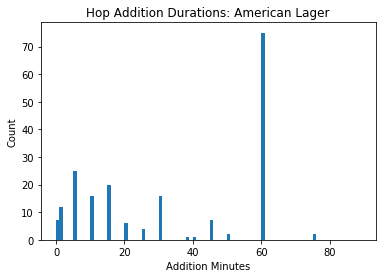

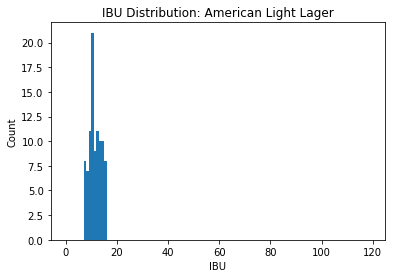

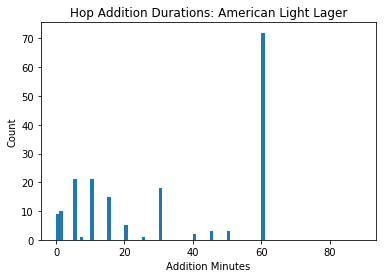

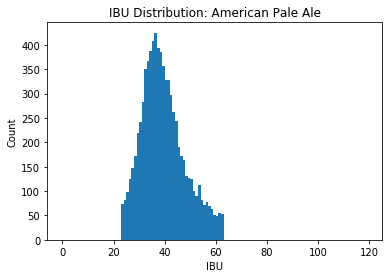

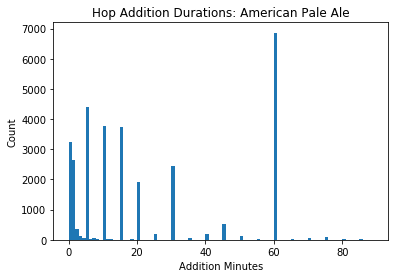

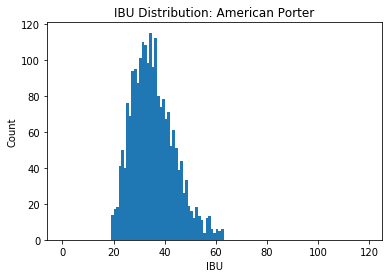

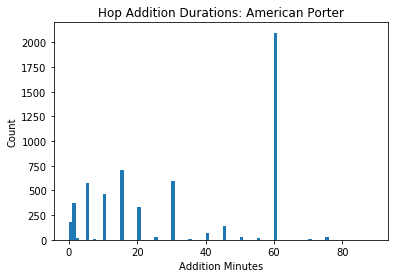

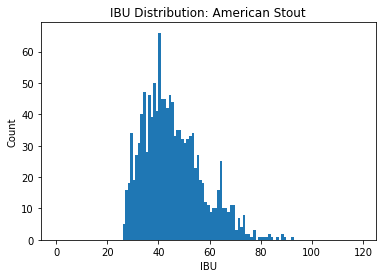

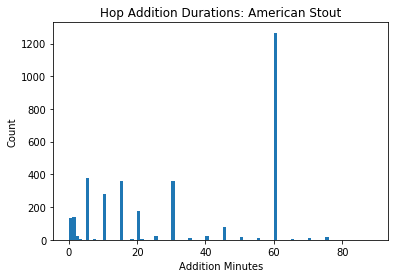

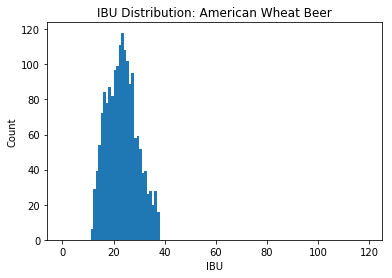

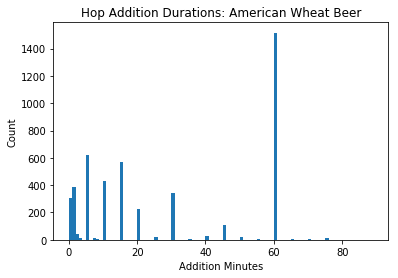

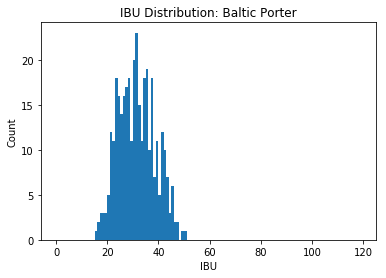

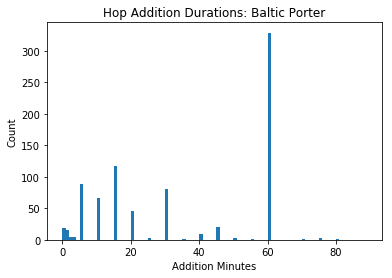

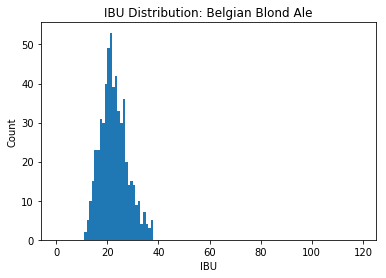

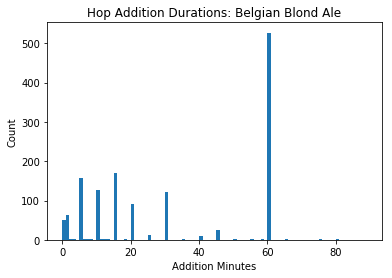

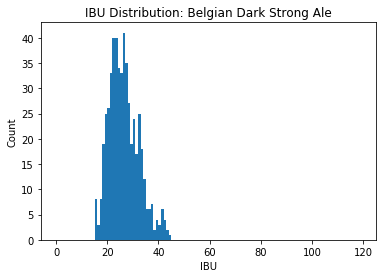

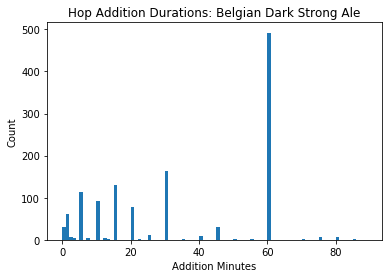

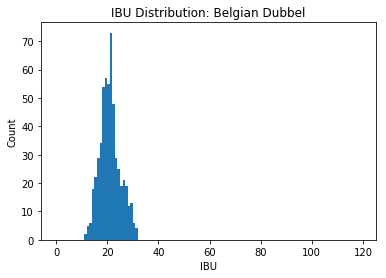

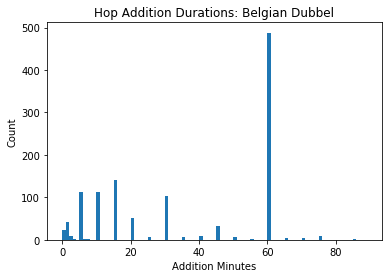

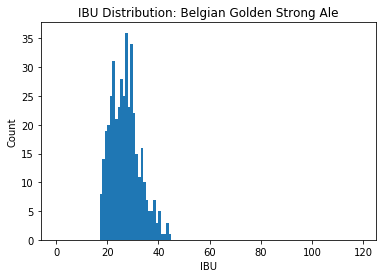

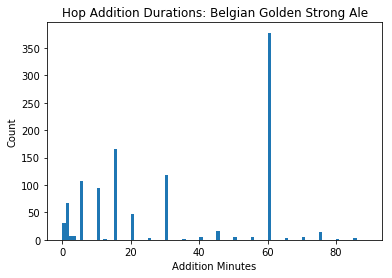

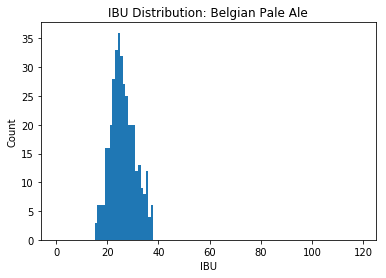

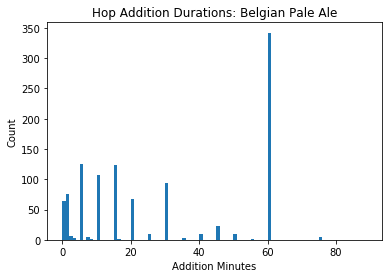

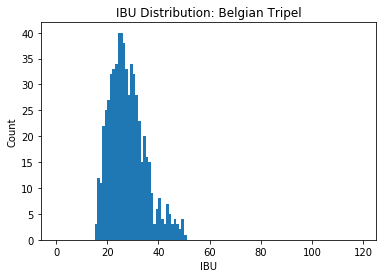

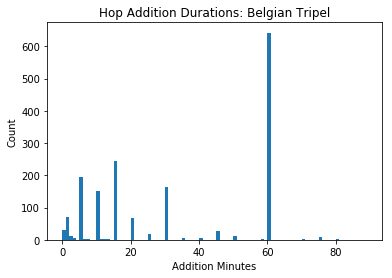

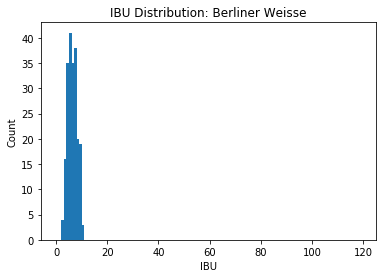

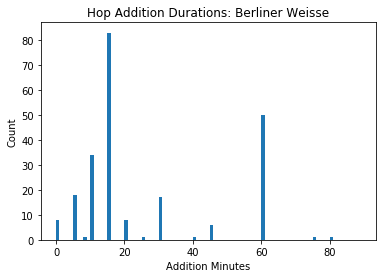

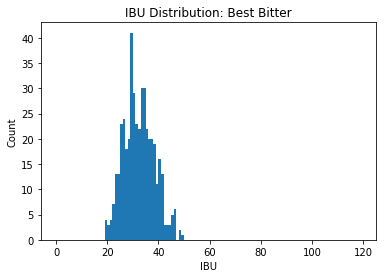

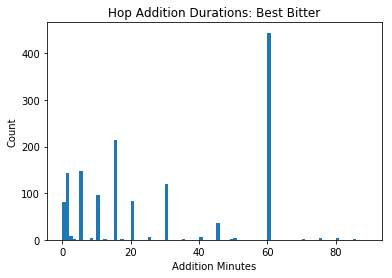

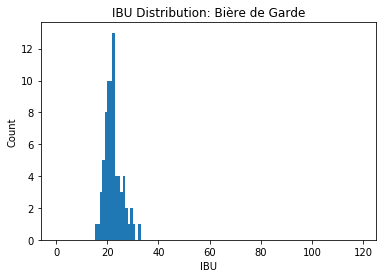

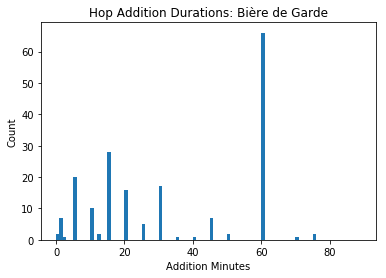

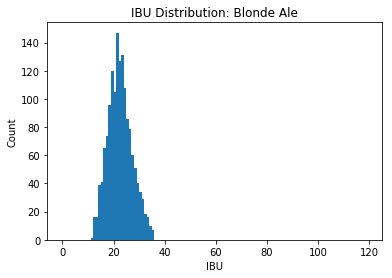

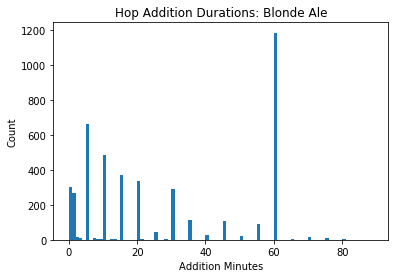

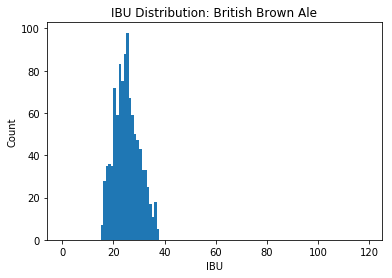

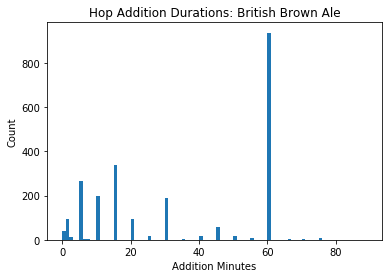

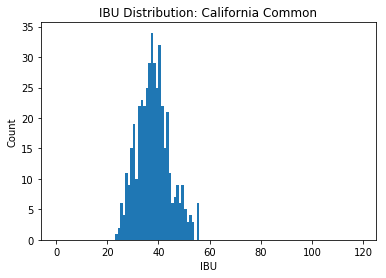

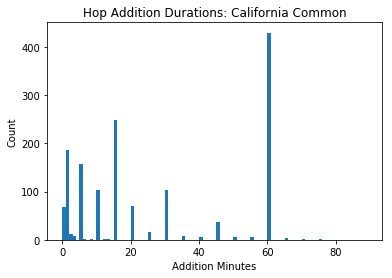

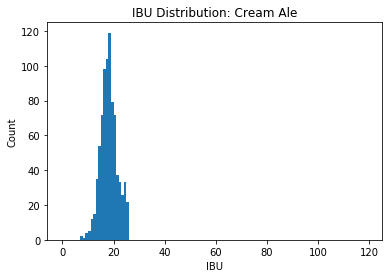

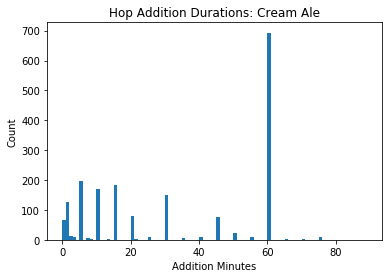

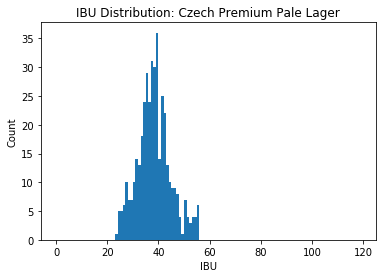

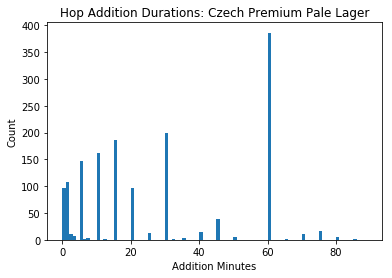

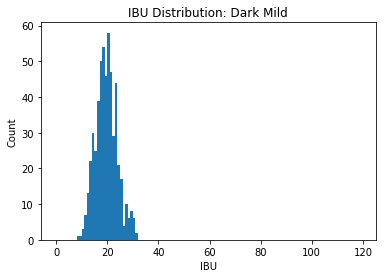

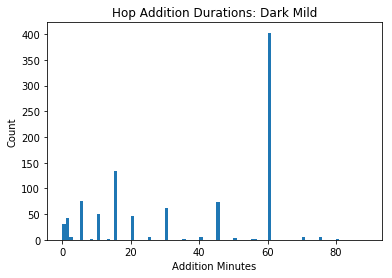

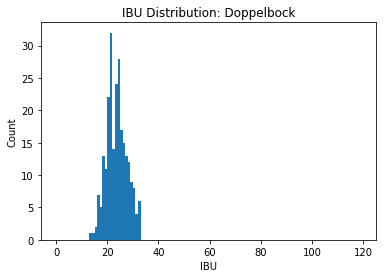

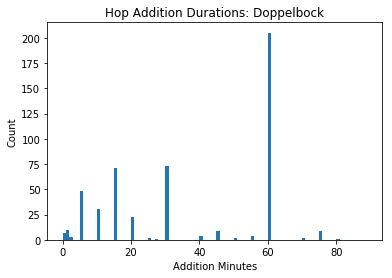

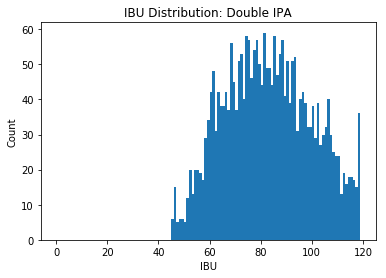

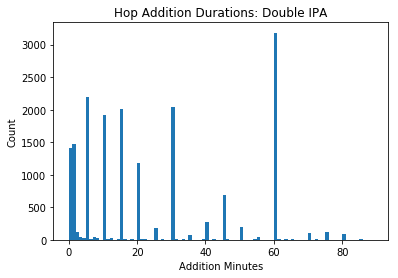

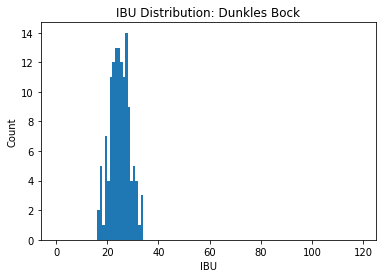

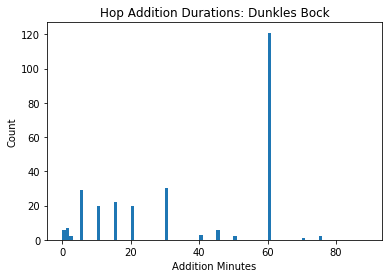

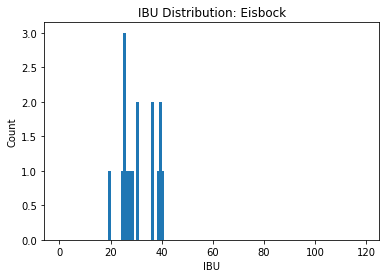

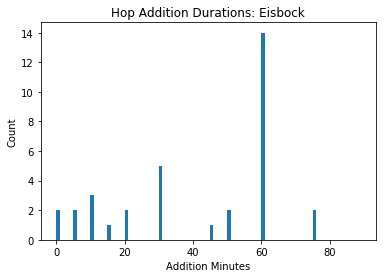

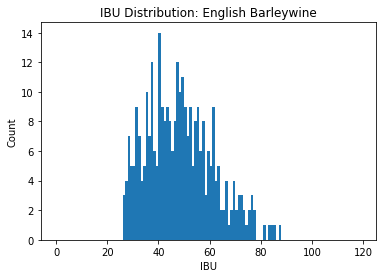

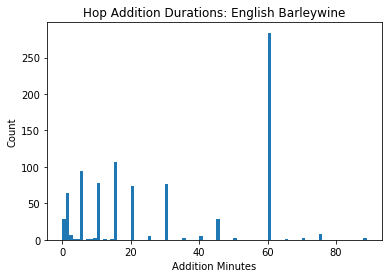

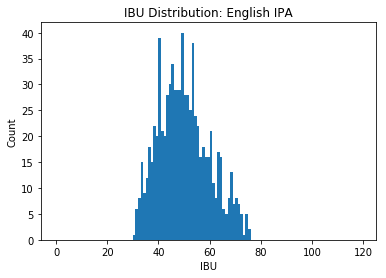

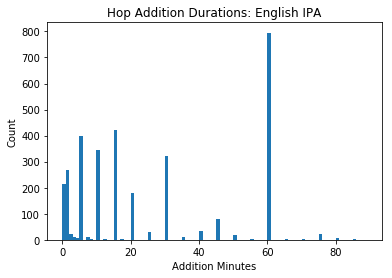

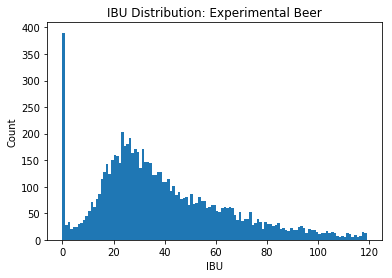

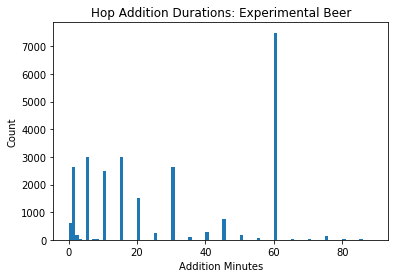

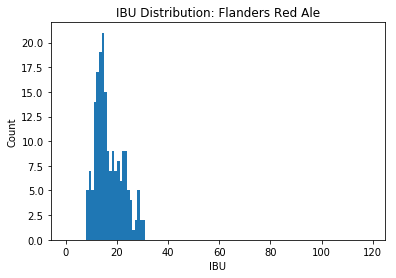

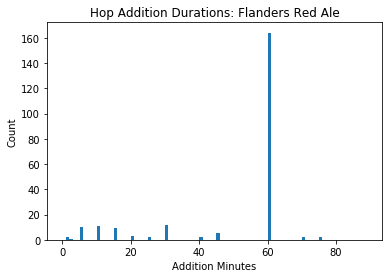

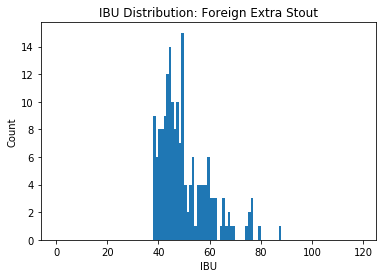

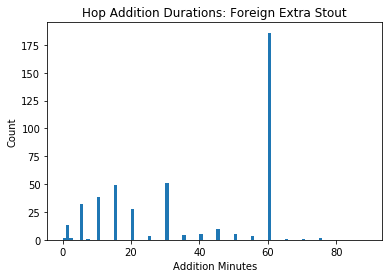

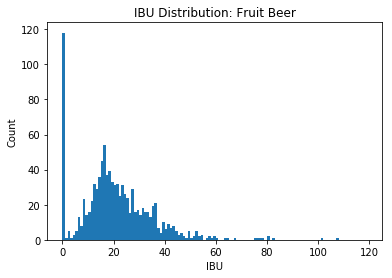

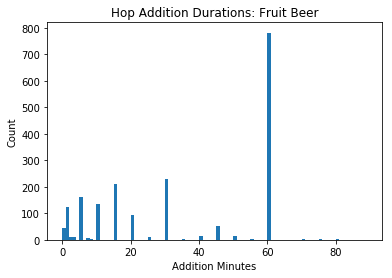

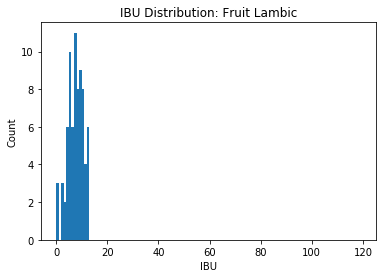

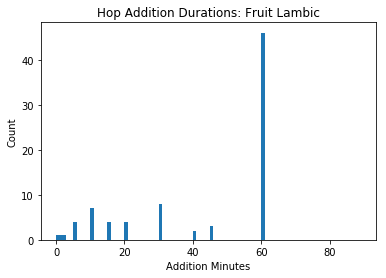

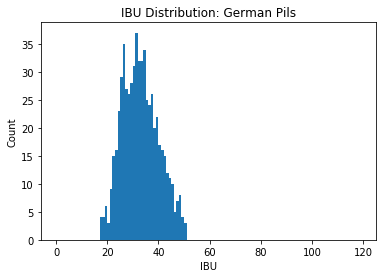

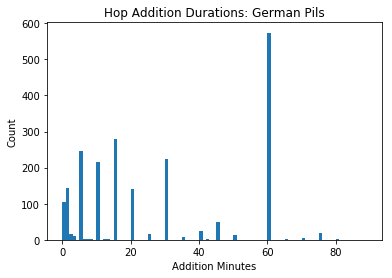

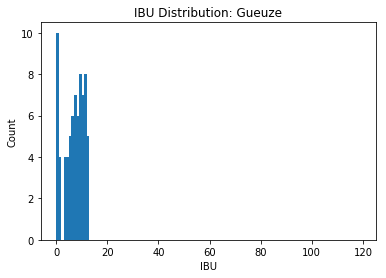

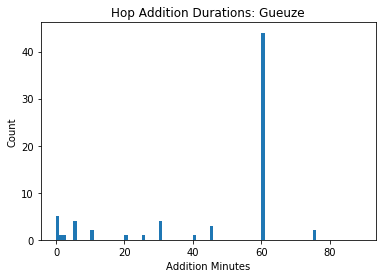

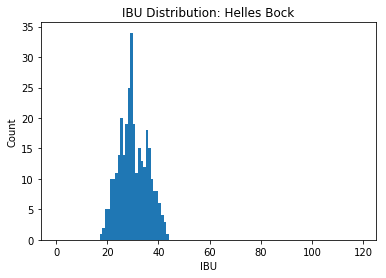

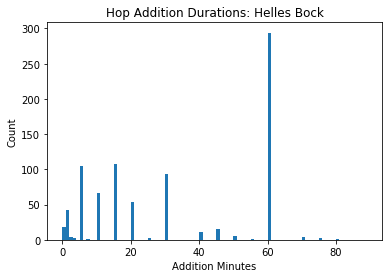

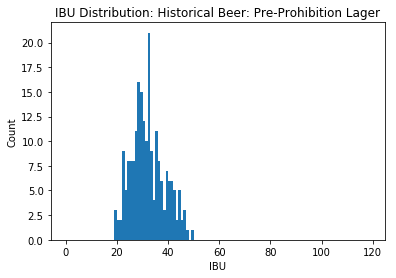

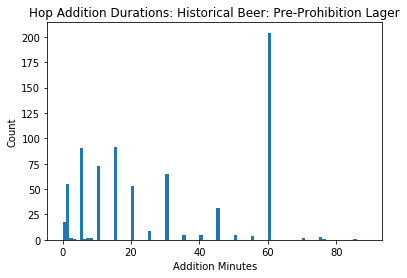

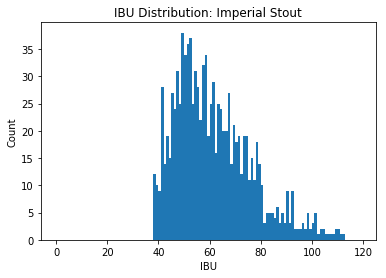

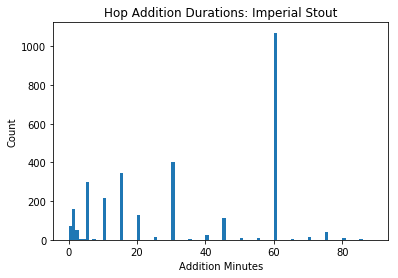

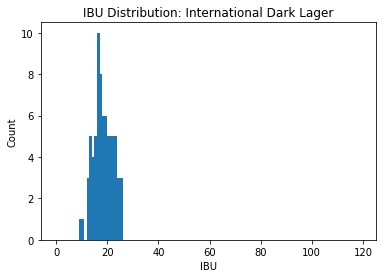

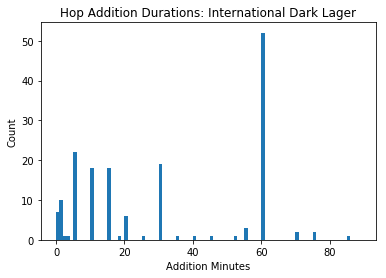

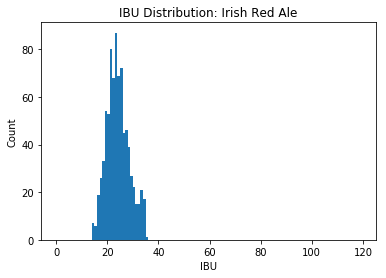

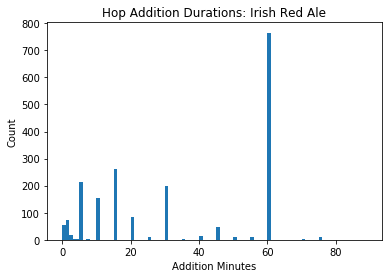

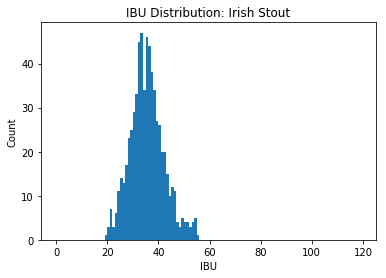

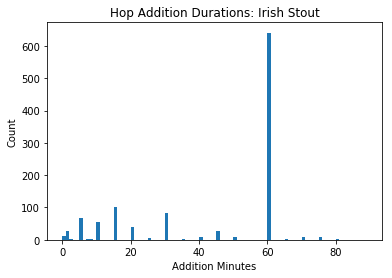

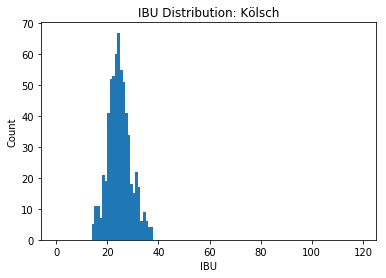

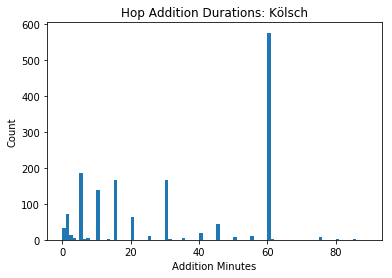

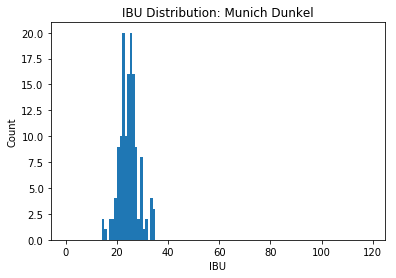

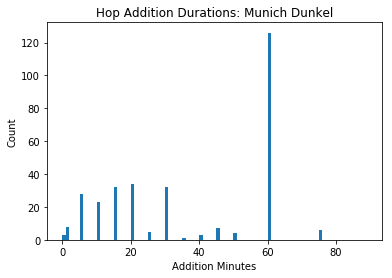

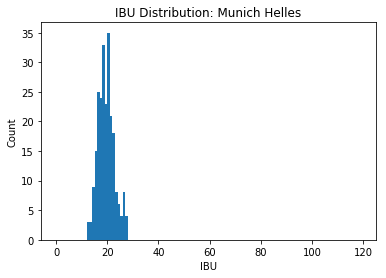

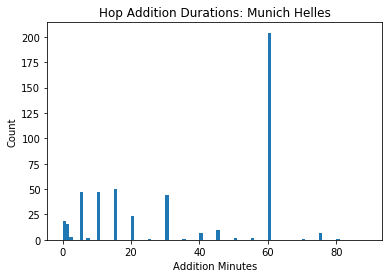

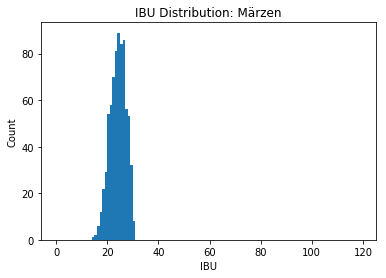

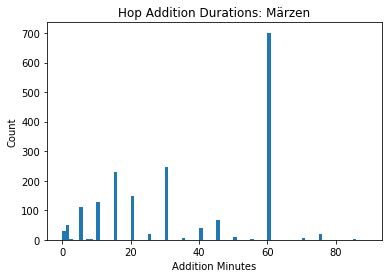

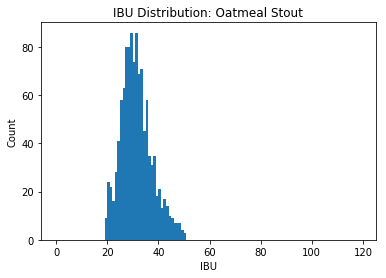

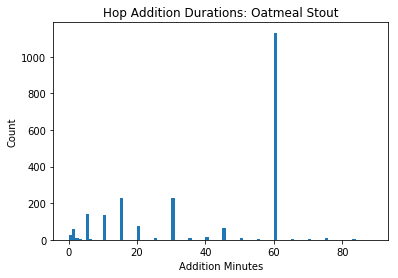

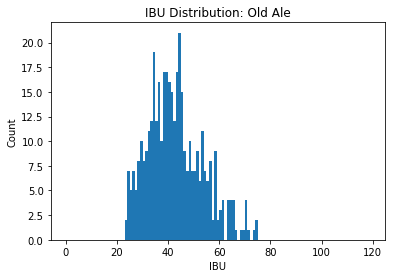

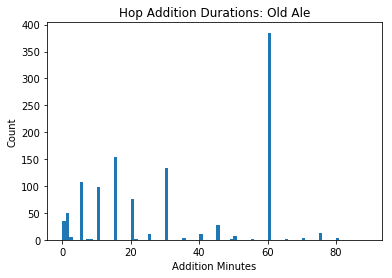

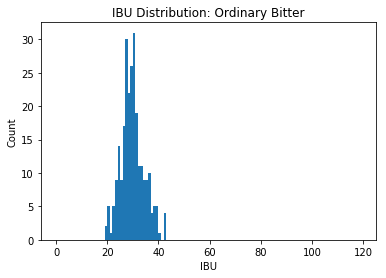

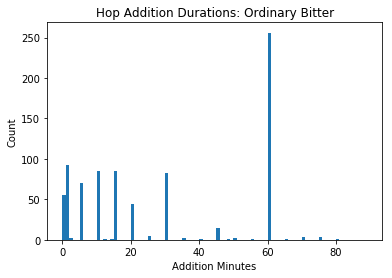

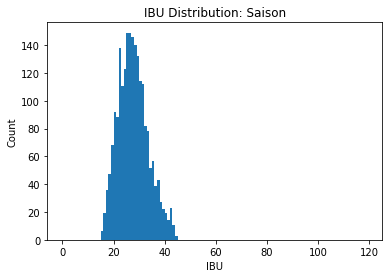

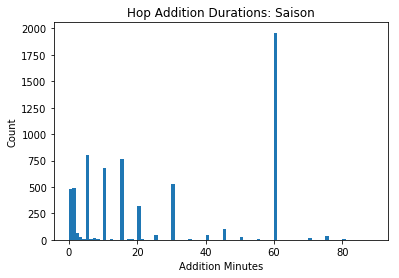

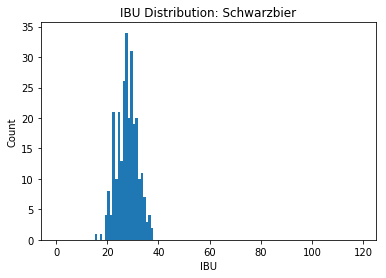

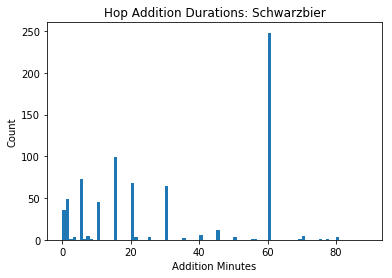

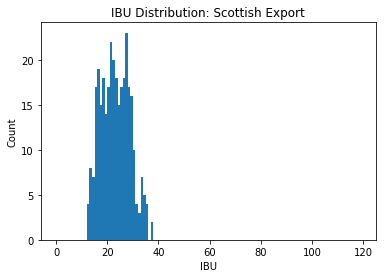

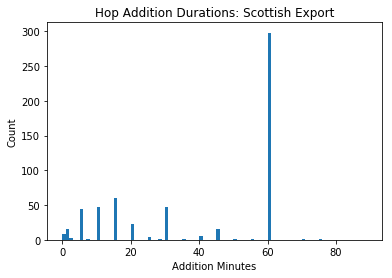

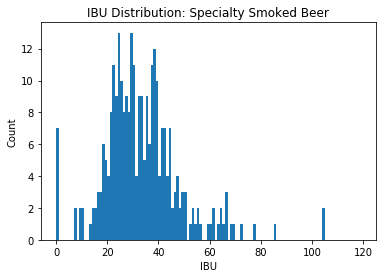

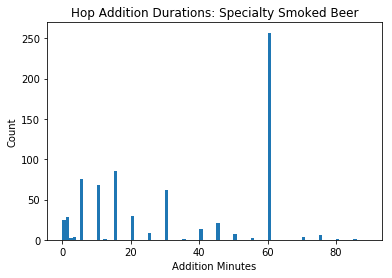

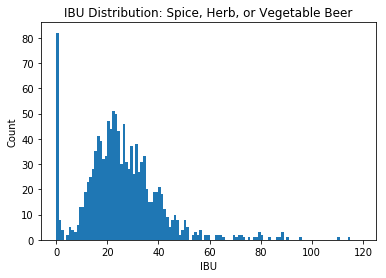

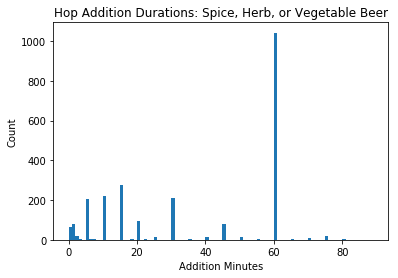

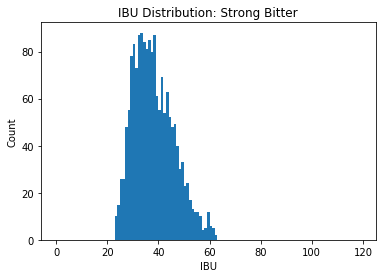

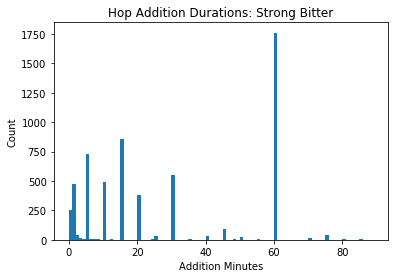

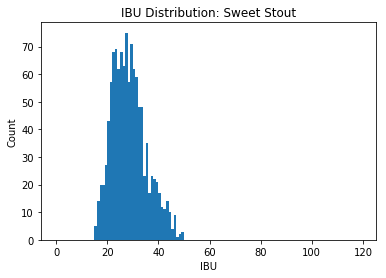

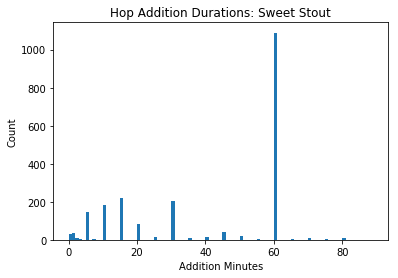

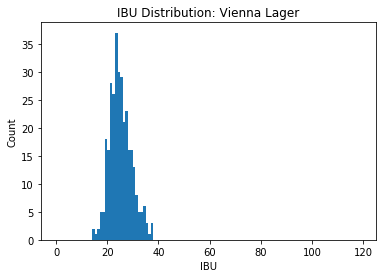

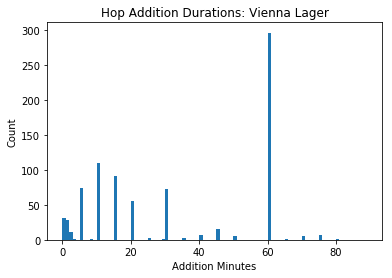

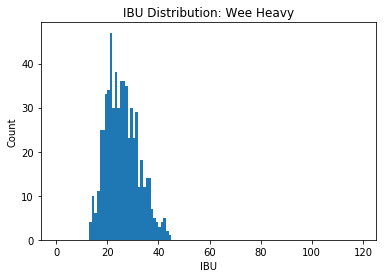

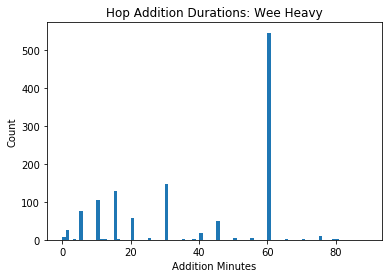

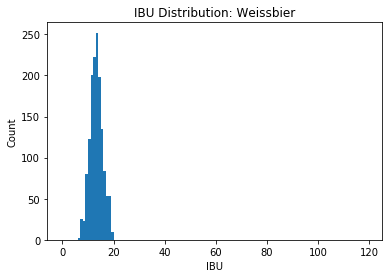

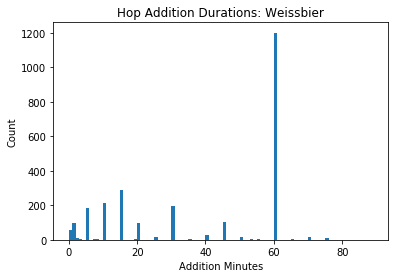

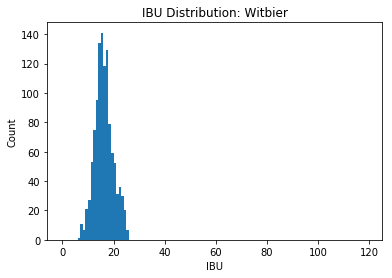

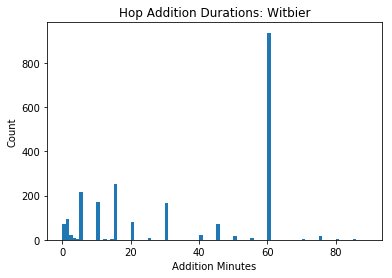

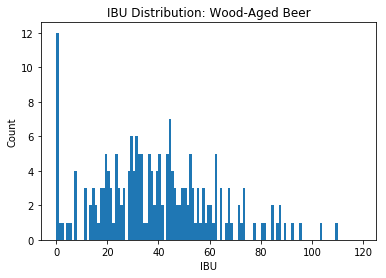

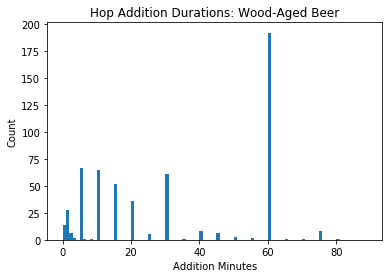

In [10]:
for style in styles:
    style_recipes = [recipe for recipe in recipes if recipe.style.name == style]
    ibu = [round(recipe.ibu) for recipe in style_recipes]
    plt.title('IBU Distribution: {}'.format(style))
    plt.xlabel('IBU')
    plt.ylabel('Count')
    plt.hist(ibu, bins=range(0, 120))
    plt.show()
    
    duration = []
    for recipe in style_recipes:
        for hop in recipe.hops:
            if hop.time <= 90:
                duration.append(round(hop.time))
    plt.title('Hop Addition Durations: {}'.format(style))
    plt.xlabel('Addition Minutes')
    plt.ylabel('Count')
    plt.hist(duration, bins=range(0, max(duration)))
    plt.show()

In [63]:
with open('all_hops.csv', 'w') as f:
    writer = csv.DictWriter(
        f, fieldnames=['name', 'total'])
    writer.writeheader()
    writer.writerows(hop_totals)

In [ ]:
flavor_data = [round(flavor * 100) for _, flavor, _ in hop_data]
plt.title('Flavor')
plt.hist(flavor_data, bins=range(0, 600))
plt.show()